# trading_oanda/oanda.ipynb

doc: https://oanda-api-v20.readthedocs.io/en/latest/index.html

instruments: https://www.oanda.com/sg-en/trading/instruments/

In [4]:
import yaml
import oandapyV20
with open('../config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
access_token = config['access_token']
accountID = config['accountID']

In [5]:
import pandas as pd
from datetime import datetime
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.orders as orders

class Oanda:
    def __init__(self, accountID, access_token):
        self.accountID = accountID
        self.access_token = access_token
        self.client = oandapyV20.API(access_token)

    def get_data(self, instrument, count, granularity):
        r = instruments.InstrumentsCandles(instrument, {'count': count, 'granularity': granularity})
        self.client.request(r)
        format_candle = lambda d: {'v': d['volume'],
                                   't': datetime.strptime(d['time'][:-4], "%Y-%m-%dT%H:%M:%S.%f").timestamp(),
                                   **{key: float(val) for key, val in d['mid'].items()}}
        return list(map(format_candle, r.response['candles']))
    
    def get_historic(self, instrument, count, granularity):
        d = self.get_data(instrument, count, granularity)
        return pd.DataFrame(d)
    
    def get_account(self):
        r = accounts.AccountDetails(self.accountID)
        self.client.request(r)
        return r.response
    
    def get_orders(self):
        account = self.get_account()
        return account['account']['orders']
    
    def buy(self, instrument, units):
        data = {'order': {
                'units': units,
                'instrument': instrument}}
        r = orders.OrderCreate(self.accountID, data)
        self.client.request(r)
        return r.response

In [6]:
oanda = Oanda(accountID, access_token)
oanda.get_data('AUD_USD', 1, 'S5')
# oanda.get_account()
# oanda.get_orders()
# oanda.buy('AUD_USD', 1)
oanda.get_historic('AUD_USD', 5, 'S5')

,v,t,o,h,l,c
0,2,1.595314e+09,0.71002,0.71002,0.71000,0.71000
1,3,1.595314e+09,0.70996,0.70996,0.70989,0.70989
2,4,1.595314e+09,0.70986,0.70986,0.70982,0.70982
3,3,1.595314e+09,0.70978,0.70978,0.70976,0.70978
4,1,1.595314e+09,0.70975,0.70975,0.70975,0.70975


In [27]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Algorithm:
    def __init__(self, oanda, instrument, granularity, strategy, capital, indicator=None):
        self.oanda = oanda  # Oanda class to call oanda api
        self.instrument = instrument  # e.g. 'AUD_USD'
        self.granularity = granularity  # e.g. 'S5'
        if indicator:
            self.indicator = indicator  # e.g. pd.DataFrame, AUD-USD
        else:
            self.indicator = oanda.get_historic(instrument, 1000, granularity)
        self.strategy = strategy  # e.g. Strategy, MACDStrategy
        self.capital = capital  # e.g. 1000
        self.data_col = ['v', 't', 'o', 'l', 'c']
        self.performance_col = ['action',
                                'balance',
                                'balance_change',
                                'stock',
                                'return',
                                'alpha',
                                'sharpe',
                                'annual_sharpe',
                                'sortino']
        for col in self.performance_col:
            self.indicator[col] = None
        
    def accept(self, observation):
        # Integrate incoming new data
        self.indicator = self.indicator.append(pd.Series(observation), ignore_index=True)
    
    def balance(self):
        # Compute the balance remaining
        self.indicator['balance_change'] = -1 * self.indicator['action'] * self.indicator['o']
        self.indicator['stock'] = self.indicator['action'].cumsum()
        self.indicator['balance'] = self.capital + self.indicator['balance_change'].cumsum()
    
    def performance(self):
        self.indicator['return'] = self.indicator['balance'] - self.capital
        self.indicator['alpha'] = self.indicator['return'] / self.capital
#         self.indicator['beta'] = 
        self.indicator['sharpe'] = self.indicator['return'].mean() / self.indicator['return'].std()
        self.indicator['annual_sharpe'] = 252**0.5 * self.indicator['sharpe']
        self.indicator['sortino'] = self.indicator['return'].mean() / \
                                    self.indicator[self.indicator['return'] < 0]['return'].std()
        
    def act(self, observation=None):
        if observation:  # for testing
            self.accept(observation)
        else:  # actual call
            observation = pd.Series(self.oanda.get_data('AUD_USD', 1, 'S5')[0])
            self.accept(observation)
            self.strategy.action(self.indicator)
            action = self.indicator['action'].iloc[-1]
            if action == 1:
                oanda.buy(self.instrument, 1)
                print("BUY")
            elif action == -1:
                oanda.buy(self.instrument, -1)
                print("SELL")
            else:
                print("NOTHING")

        self.balance()
        self.performance()
        
    def statistics(self, k=100):
        return self.indicator[self.data_col + \
                              self.performance_col].iloc[-1].to_dict()
    
    def plot_indicators(self, k=100):
        self.strategy.plot(self.indicator, k=k)
        
    def plot_performance(self, k=100):
        ax1 = plt.axes()
        ax1.plot(self.indicator['o'][-k:], label='o', c='r')
        ax1.set_ylabel("Opening")
        plt.legend(loc='best')
        ax2 = ax1.twinx() 
        ax2.plot(self.indicator['balance'][-k:], label='balance')
        ax2.set_ylabel("balance")
        plt.legend(loc='best')
        plt.show()
        
from ta.trend import MACD

class MACDStrategy:
    def __init__(self, parameters):
        self.parameters = parameters  # e.g. Dictionary, {'ema26':26, 'ema12':12, 'ema9':9}
        self.indicator_col = ['trend_macd',
                              'trend_macd_signal',
                              'trend_macd_diff']
        
    def action(self, indicator):
        # Derive the action based on past data
        # action: 1 means buy, -1 means sell, 0 means do nothing
        close = indicator['c']
        macd = MACD(close=close,
                   n_slow=self.parameters['ema26'],
                   n_fast=self.parameters['ema12'],
                   n_sign=self.parameters['ema9'])
        indicator['trend_macd'] = macd.macd()
        indicator['trend_macd_signal'] = macd.macd_signal()
        indicator['trend_macd_diff'] = macd.macd_diff()
        indicator['trend_macd_diff_prev'] = indicator['trend_macd_diff'].shift(1)
        indicator['action'] = (np.sign(indicator['trend_macd_diff']) \
                                    - np.sign(indicator['trend_macd_diff_prev'])) / 2
        
    def plot(self, indicator, k=100):
        plt.plot(indicator['trend_macd'][-k:], label='trend_macd')
        plt.plot(indicator['trend_macd_diff'][-k:], label='trend_macd_diff')
        plt.plot(indicator['trend_macd_signal'][-k:], label='trend_macd_signal')
        plt.legend(loc='best')
        plt.show()
        
from ta.volume import MFIIndicator


class MFIStrategy:
    def __init__(self, parameters):
        self.parameters = parameters  # e.g. Dictionary, {'mfi80':80, 'mfi20':20}
        self.indicator_col = ["volume_mfi"]

    def action(self, indicator):
        # Derive the action based on past data
        # action: 1 means buy, -1 means sell, 0 means do nothing
        high, low, close, volume = (
            indicator["h"],
            indicator["l"],
            indicator["c"],
            indicator["v"],
        )
        indicator["volume_mfi"] = MFIIndicator(
            high=high, low=low, close=close, volume=volume
        ).money_flow_index()
        indicator["volume_mfi_prev"] = indicator["volume_mfi"].shift(1)

        # If 80 -> 79: Sell, If 19 -> 20: Buy
        indicator["sell"] = (
            (indicator["volume_mfi_prev"] >= self.parameters["mfi80"])
            & (indicator["volume_mfi"] < self.parameters["mfi80"])
        ).astype(int)
        indicator["buy"] = (
            (indicator["volume_mfi_prev"] < self.parameters["mfi20"])
            & (indicator["volume_mfi"] >= self.parameters["mfi20"])
        ).astype(int)
        indicator["action"] = indicator["buy"] - indicator["sell"]

    def plot(self, indicator, k=100):
        plt.plot(indicator["volume_mfi"][-k:], label="volume_mfi")
        plt.legend(loc="best")
        plt.show()
        
from ta.momentum import RSIIndicator


class RSIStrategy:
    def __init__(self, parameters):
        self.parameters = parameters  # e.g. Dictionary, {'rsi70': 70, 'rsi30': 30}
        self.indicator_col = ["momentum_rsi"]

    def action(self, indicator):
        # Derive the action based on past data
        # action: 1 means buy, -1 means sell, 0 means do nothing
        close = indicator["c"]
        indicator["momentum_rsi"] = RSIIndicator(close=close).rsi()
        indicator["momentum_rsi_prev"] = indicator["momentum_rsi"].shift(1)

        # If 69 -> 70: Sell, If 30 -> 29: Buy
        indicator["sell"] = (
            (indicator["momentum_rsi_prev"] < self.parameters["rsi70"])
            & (indicator["momentum_rsi"] >= self.parameters["rsi70"])
        ).astype(int)
        indicator["buy"] = (
            (indicator["momentum_rsi_prev"] >= self.parameters["rsi30"])
            & (indicator["momentum_rsi"] < self.parameters["rsi30"])
        ).astype(int)
        indicator["action"] = indicator["buy"] - indicator["sell"]

    def plot(self, indicator, k=100):
        plt.plot(indicator["momentum_rsi"][-k:], label="momentum_rsi")
        plt.legend(loc="best")
        plt.show()


In [8]:
macd = MACDStrategy(
    parameters={
        'ema26': 26,
        'ema12': 12,
        'ema9': 9})
algo = Algorithm(
    oanda=oanda,
    instrument='AUD_USD',
    granularity='S5',
    strategy=macd,
    capital=1000)

In [13]:
mfi = MFIStrategy(
    parameters={
        'mfi80': 80,
        'mfi20': 20})
algo = Algorithm(
    oanda=oanda,
    instrument='AUD_USD',
    granularity='S5',
    strategy=mfi,
    capital=1000)

In [28]:
rsi = RSIStrategy(
    parameters={'rsi70': 70, 'rsi30': 30})
algo = Algorithm(
    oanda=oanda,
    instrument='AUD_USD',
    granularity='S5',
    strategy=rsi,
    capital=1000)

In [43]:
algo.act()

ConnectionError: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))

In [30]:
algo.indicator['t']

0       1.595308e+09
1       1.595308e+09
2       1.595308e+09
3       1.595308e+09
4       1.595308e+09
            ...     
996     1.595315e+09
997     1.595315e+09
998     1.595315e+09
999     1.595315e+09
1000    1.595315e+09
Name: t, Length: 1001, dtype: float64

In [23]:
import time
while True:
    algo.act()
#     print(i, algo.statistics())
    time.sleep(5)

NOTHING
NOTHING
NOTHING
NOTHING
NOTHING
NOTHING
NOTHING
NOTHING
NOTHING


KeyboardInterrupt: 

In [42]:
algo.indicator

,v,t,o,h,l,c,action,balance,balance_change,stock,return,alpha,sharpe,annual_sharpe,sortino,momentum_rsi,momentum_rsi_prev,sell,buy
0,2.0,1.595308e+09,0.70937,0.70937,0.70934,0.70934,0,1000.00000,0.0,0,0.00000,0.000000,0.087892,1.395245,0.269918,NaN,NaN,0,0
1,3.0,1.595308e+09,0.70938,0.70942,0.70938,0.70938,0,1000.00000,0.0,0,0.00000,0.000000,0.087892,1.395245,0.269918,NaN,NaN,0,0
2,2.0,1.595308e+09,0.70941,0.70941,0.70938,0.70938,0,1000.00000,0.0,0,0.00000,0.000000,0.087892,1.395245,0.269918,NaN,NaN,0,0
3,1.0,1.595308e+09,0.70934,0.70934,0.70934,0.70934,0,1000.00000,0.0,0,0.00000,0.000000,0.087892,1.395245,0.269918,NaN,NaN,0,0
4,4.0,1.595308e+09,0.70938,0.70938,0.70928,0.70928,0,1000.00000,0.0,0,0.00000,0.000000,0.087892,1.395245,0.269918,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1.0,1.595315e+09,0.71070,0.71070,0.71070,0.71070,0,1004.26633,0.0,-6,4.26633,0.004266,0.087892,1.395245,0.269918,61.216222,58.406399,0,0
997,3.0,1.595315e+09,0.71066,0.71066,0.71064,0.71066,0,1004.26633,0.0,-6,4.26633,0.004266,0.087892,1.395245,0.269918,57.064724,61.216222,0,0
998,6.0,1.595315e+09,0.71070,0.71070,0.71060,0.71067,0,1004.26633,0.0,-6,4.26633,0.004266,0.087892,1.395245,0.269918,57.834597,57.064724,0,0
999,3.0,1.595315e+09,0.71070,0.71070,0.71066,0.71070,0,1004.26633,0.0,-6,4.26633,0.004266,0.087892,1.395245,0.269918,60.143523,57.834597,0,0


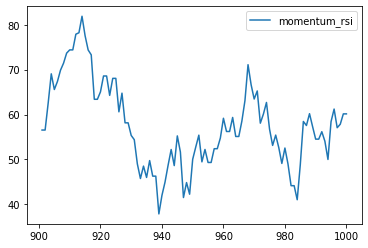

In [32]:
algo.plot_indicators()

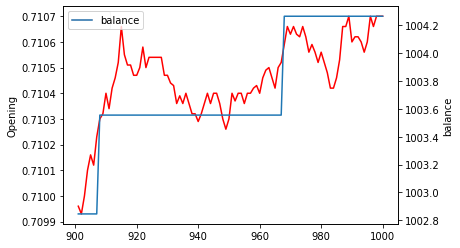

In [33]:
algo.plot_performance()

In [34]:
algo.performance_col

['action',
 'balance',
 'balance_change',
 'stock',
 'return',
 'alpha',
 'sharpe',
 'annual_sharpe',
 'sortino']

In [41]:
algo.indicator[algo.performance_col].values[-3:, :].T.tolist()

[[0.0, 0.0, 0.0],
 [1004.26633, 1004.26633, 1004.26633],
 [0.0, 0.0, 0.0],
 [-6.0, -6.0, -6.0],
 [4.266330000000039, 4.266330000000039, 4.266330000000039],
 [0.004266330000000039, 0.004266330000000039, 0.004266330000000039],
 [0.08789219360286264, 0.08789219360286264, 0.08789219360286264],
 [1.3952453187427, 1.3952453187427, 1.3952453187427],
 [0.26991790441476726, 0.26991790441476726, 0.26991790441476726]]